In [2]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#math
import numpy as np
import math as m

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt

In [13]:
set_number = 5

dirx = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
dir_save = '../../../Research/Images/Images/figureMar24/'

wind_load= 'wind0'+str(set_number)+'Run03_Interpolated.hdf'
wind_load_small = 'wind0'+str(set_number)+'Run03_Interpolatedsmall.hdf'

windn = pd.read_hdf(dirx+wind_load)
windsm = pd.read_hdf(dirx+wind_load_small)

In [11]:
st=windn.master_time-windn.master_time[0]

In [3]:
#the complete bag6data

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/'
odor_load = 'Run03Set05.h5'
df = pd.read_hdf(dir+odor_load)

In [4]:
df = df.reset_index()
df = df.rename(columns={"index": "master_time"}) 

In [5]:
sync_time = df.master_time - df.master_time[0]
df.insert(1, 'time', sync_time)

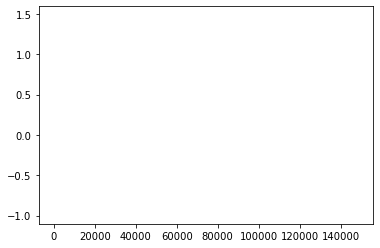

In [7]:
plt.plot(df._trisonica_updown)

In [7]:
df = df[df.columns.drop(list(df.filter(regex='frame_id')))]
df.keys()

Index(['master_time', 'time', '_trisonica_direction', '_trisonica_header_seq',
       '_trisonica_header_stamp_nsecs', '_trisonica_header_stamp_secs',
       '_trisonica_humidity', '_trisonica_northsouth', '_trisonica_pitch',
       '_trisonica_pressure', '_trisonica_roll', '_trisonica_speed',
       '_trisonica_temperature', '_trisonica_updown', '_trisonica_westeast',
       '_imu_data_angular_velocity_x', '_imu_data_angular_velocity_y',
       '_imu_data_angular_velocity_z', '_imu_data_header_seq',
       '_imu_data_header_stamp_nsecs', '_imu_data_header_stamp_secs',
       '_imu_data_linear_acceleration_x', '_imu_data_linear_acceleration_y',
       '_imu_data_linear_acceleration_z', '_imu_data_orientation_w',
       '_imu_data_orientation_x', '_imu_data_orientation_y',
       '_imu_data_orientation_z', '_ublox_gps_fix_altitude',
       '_ublox_gps_fix_header_seq', '_ublox_gps_fix_header_stamp_nsecs',
       '_ublox_gps_fix_header_stamp_secs', '_ublox_gps_fix_latitude',
       '_ublo

In [9]:
dt=df.master_time[1]-df.master_time[0]

In [11]:
# lin_vel_x = [np.sum(df._imu_data_linear_acceleration_x[j:])*dt for j in range(0,len(df))]

In [ ]:
velocity_list = [sum(acceleration_list[:i]) for i in range(len(acceleration_list))]

In [85]:
t_odor = np.array(df.query('_analog_output_data>0')['master_time'])

In [99]:
x = (df.query('_analog_output_data>0')['master_time'])

In [104]:
# sensor_speed = (df.query('_analog_output_data>0')[''])

In [87]:
df_o = pd.DataFrame()
df_o['intermittency'] = t_odor

In [92]:
# df_o = df_o.reset_index
df_o['timestep']=df_o['intermittency'] -df_o['intermittency'].shift(1)
df_o.timestep[0] =0

In [95]:
wind_speed = np.array(df.query('df>0')['master_time'])

60000

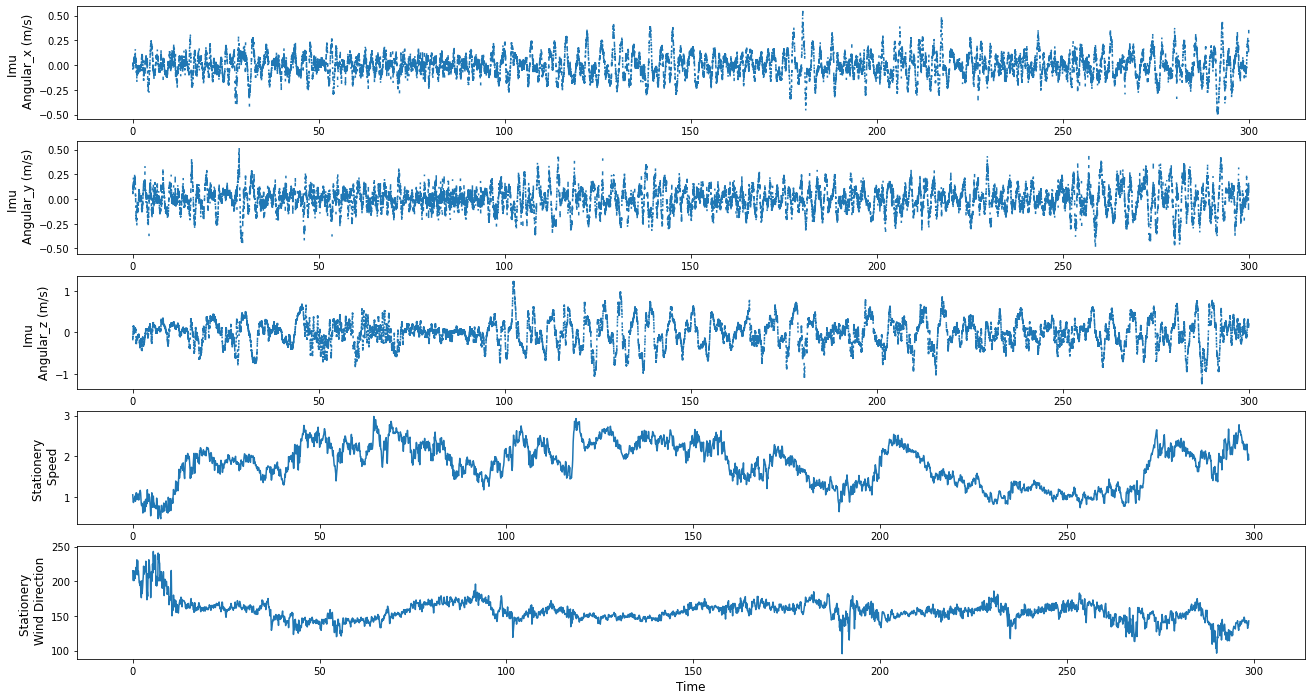

In [18]:
f, (ax1,ax2,ax3,ax4, ax5) = plt.subplots(5, 1,figsize=(22,12))
ax1.plot(df.time, df._imu_data_angular_velocity_x)
ax1.set_ylabel('Imu \n Angular_x (m/s)', fontsize=12)
ax2.plot(df.time,df._imu_data_angular_velocity_y)
# ax2.set_xlabel('Time (secs)', fontsize=20)
ax2.set_ylabel('Imu \n Angular_y (m/s)', fontsize=12)
# ax2.title.set_text('Calculated Particle')
ax3.plot(df.time,df._imu_data_angular_velocity_z)
ax3.set_ylabel('Imu \n Angular_z (m/s) ', fontsize=12)

ax4.plot(st,windn.S2)
ax4.set_ylabel('Stationery \n Speed', fontsize=12)

ax5.plot(st, windn.D)
ax5.set_xlabel('Time', fontsize=12)
ax5.set_ylabel('Stationery \n Wind Direction', fontsize=12)

# f.suptitle('Radius time**0.5*.01', fontsize =20)

f.savefig(dir_save+'Run03Set0'+str(set_number)+'imu_comp.jpeg')

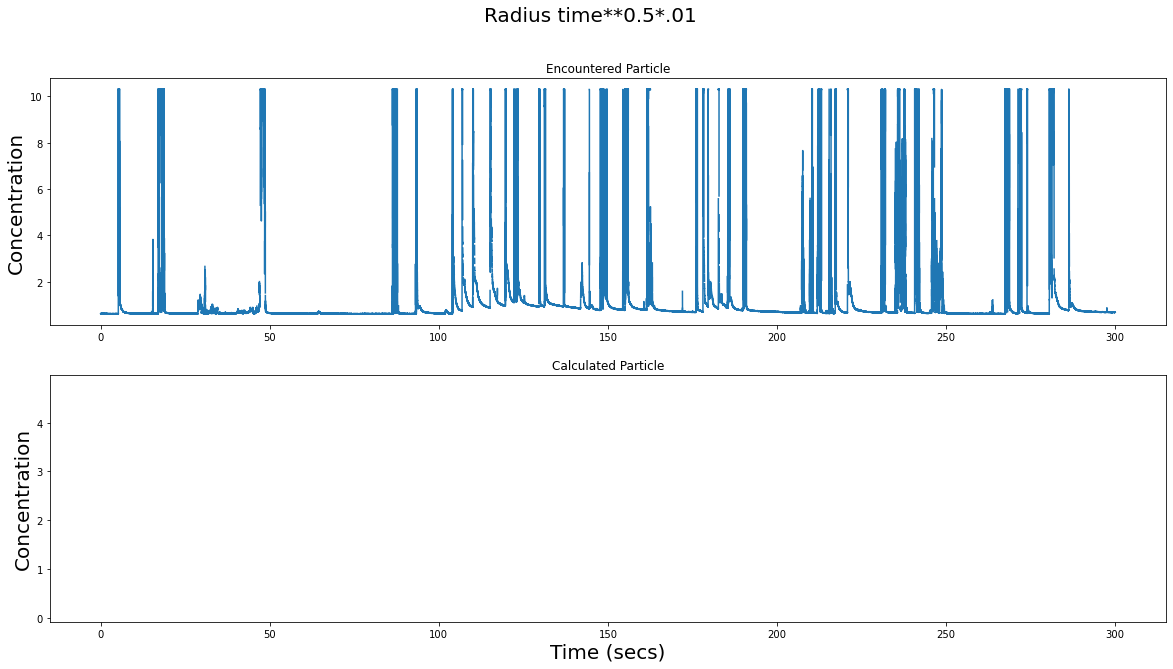

In [30]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(20,10))
ax1.plot(df.time, df._analog_output_data)
ax1.set_ylabel('Concentration', fontsize=20)
ax1.title.set_text('Encountered Particle')
ax2.plot(df.time,df._trisonica_speed)
ax2.set_xlabel('Time (secs)', fontsize=20)
ax2.set_ylabel('Concentration', fontsize=20)
ax2.title.set_text('Calculated Particle')

f.suptitle('Radius time**0.5*.01', fontsize =20)
f.savefig('encounteredVsExpected.jpeg')

Text(0, 0.5, 'Odor')

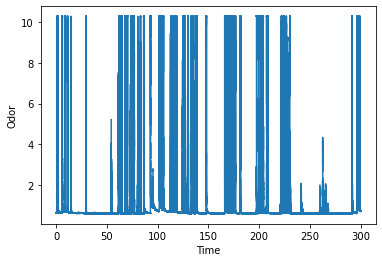

In [20]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(df.sync_time, df._analog_output_data)
ax.set_xlabel('Time')
ax.set_ylabel('Odor')

#hp.plot_color(ax)

Text(0, 0.5, 'Frequency')

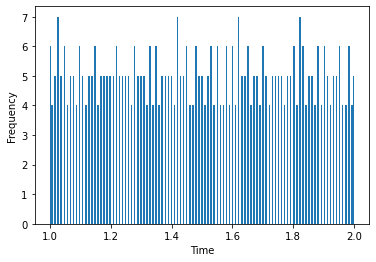

In [4]:
fig_t = plt.figure()

odx = fig_t.add_subplot(111)
bins = np.linspace(1,2,200)
odx.hist(df.time, bins=bins)
odx.set_xlabel('Time')
odx.set_ylabel('Frequency')

#hp.plot_color(odx)

In [5]:
#loading only odor data
odorname = '/home/flybot/data/2807/odor.hdf5'
of = hp.uncooperative_hdf5(odorname)
of.data = of.data.astype(float)
of

Dataset contains these keys: 
['analog_output']
Using only the first key:  analog_output


,data,t_secs,t_nsecs,t
0,0.170870,1595957763,649663705,1.595958e+09
1,0.171183,1595957763,654564510,1.595958e+09
2,0.170870,1595957763,664562819,1.595958e+09
3,0.170870,1595957763,664617371,1.595958e+09
4,0.170870,1595957763,674436704,1.595958e+09
...,...,...,...,...
159902,0.132394,1595958563,159710667,1.595959e+09
159903,0.132394,1595958563,164688882,1.595959e+09
159904,0.132394,1595958563,169675507,1.595959e+09
159905,0.131768,1595958563,174647127,1.595959e+09


In [6]:
start_time=of.t[0]
of.t=of.t-start_time

Text(0, 0.5, 'Frequency')

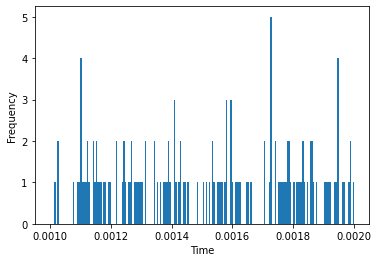

In [7]:
#histogram timestamp
df1=of.diff()
fig_t = plt.figure()

odx = fig_t.add_subplot(111)
bins = np.linspace(0.001,0.002,200)
odx.hist(df1.t, bins=bins)
odx.set_xlabel('Time')
odx.set_ylabel('Frequency')

#hp.plot_color(odx)

Text(0, 0.5, 'Odor')

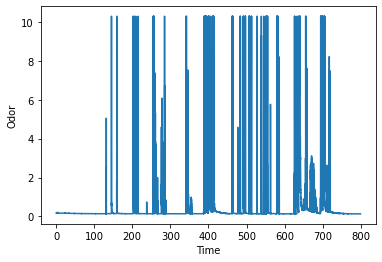

In [8]:
fig = plt.figure()

axis = fig.add_subplot(111)
axis.plot(of.t, of.data)
axis.set_xlabel('Time')
axis.set_ylabel('Odor')

#hp.plot_color(axis)

Text(0.08, 0.5, 'Odor Concentration')

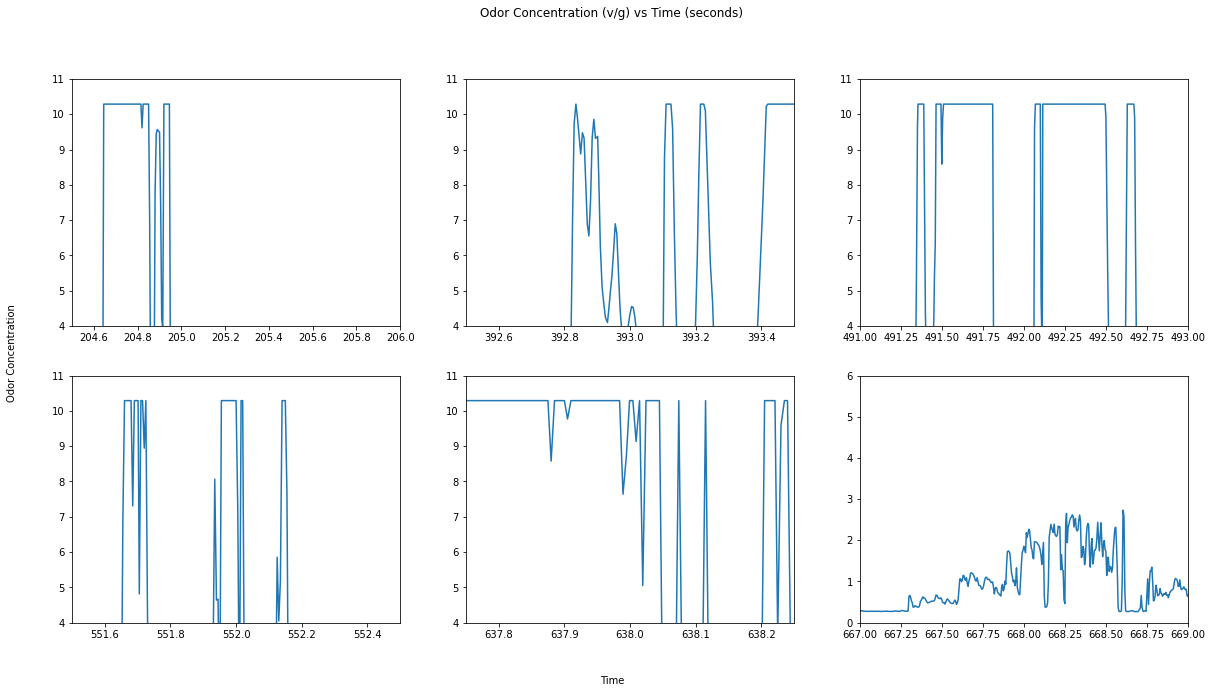

In [9]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,figsize=(20,10))
fig.suptitle('Odor Concentration (v/g) vs Time (seconds)')
ax1.plot(of.t, of.data)
ax1.set_xlim(204.5,206) #time
ax1.set_ylim(4,11) #voltage

ax2.plot(of.t, of.data)
ax2.set_xlim(392.5,393.5)
ax2.set_ylim(4,11)

ax3.plot(of.t, of.data)
ax3.set_xlim(491,493)
ax3.set_ylim(4,11)

ax4.plot(of.t, of.data)
ax4.set_xlim(551.5,552.5)
ax4.set_ylim(4,11)

ax5.plot(of.t, of.data)
ax5.set_xlim(637.75,638.25)
ax5.set_ylim(4,11)

ax6.plot(of.t, of.data)
ax6.set_xlim(667,669)
ax6.set_ylim(0,6) #lower concentration

fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.08, 0.5, 'Odor Concentration', va='center', rotation='vertical')

fig.savefig('../figure')
#hp.plot_color(ax1)
#hp.plot_color(ax2)
#hp.plot_color(ax6)


## OCTOBER 8; 2020
source [lat,long] = 39.677082964, -119.82000626249999

In [10]:
HighGainOdor = '/home/flybot/data/dataOctober/run1/October_0_odor.hdf5'
LowGainOdor = '/home/flybot/data/dataOctober/run2/October_3_odor.hdf5'
hgo = hp.uncooperative_hdf5(HighGainOdor)
lgo = hp.uncooperative_hdf5(LowGainOdor)

start_time_hgo=hgo.t[0]
start_time_lgo=lgo.t[0]
hgo.t=hgo.t-start_time_hgo
lgo.t=lgo.t-start_time_lgo
lgo

Dataset contains these keys: 
['analog_output', 'trisonica']
Using only the first key:  analog_output
Dataset contains these keys: 
['analog_output', 'trisonica']
Using only the first key:  analog_output


,data,t_secs,t_nsecs,t
0,0.181819,1602179389,792080944,0.000000
1,0.181819,1602179389,796371168,0.004290
2,0.181193,1602179389,801404059,0.009323
3,0.181193,1602179389,806775084,0.014694
4,0.181506,1602179389,811499295,0.019418
...,...,...,...,...
59957,0.185886,1602179689,576304665,299.784224
59958,0.185573,1602179689,581723568,299.789643
59959,0.185260,1602179689,586613751,299.794533
59960,0.185573,1602179689,591381657,299.799301


(60.0, 320.0)

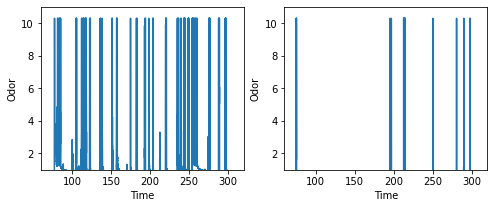

In [11]:
fig, (ax_hgo, ax_lgo) = plt.subplots(1,2,figsize=(8,3))

ax_hgo.plot(hgo.t, hgo.data)
ax_hgo.set_xlabel('Time')
ax_hgo.set_ylabel('Odor')
ax_hgo.set_ylim(1,11)
ax_hgo.set_xlim(60,320)

ax_lgo.plot(lgo.t, lgo.data)
ax_lgo.set_xlabel('Time')
ax_lgo.set_ylabel('Odor')
ax_lgo.set_ylim(1,11)
ax_lgo.set_xlim(60,320)
#hp.plot_color(axis)

### BAG CLEANUPS

In [12]:
# bag_zero = hp.import_bag("~/data/dataOctober/run1/October_0_selective.csv")
# start_time=bag_zero.loc[bag_zero.index[0], 'time']
# bag_zero.time=(bag_zero.time-start_time)
# bag_zero_data=bag_zero.interpolate()
# bag_zero_data.to_hdf('~/data/dataOctober/run1/October_0_selective.h5', key='bag_zero', mode='w')

In [13]:
bag_zero=pd.read_hdf('~/data/dataOctober/run1/October_0_selective.h5')
bag_zero

,time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,_trisonica_pitch,...,_ublox_gps_fix_position_covariance_2,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status
0,0.00,0.791815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,0.791189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.01,0.791658,284.0,NaN,1.000000,4.485490e+08,1.602178e+09,20.299999,1.600,-7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.01,0.792127,284.5,NaN,1.166667,4.525835e+08,1.602178e+09,20.299999,1.595,-7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02,0.790876,285.0,NaN,1.333333,4.566180e+08,1.602178e+09,20.299999,1.590,-7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73434,299.73,0.770230,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73435,299.74,0.765851,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73436,299.74,0.764912,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0
73437,299.75,0.767102,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0


In [14]:
bag_zero.drop(columns=['_ublox_gps_fix_position_covariance_1', '_ublox_gps_fix_position_covariance_2', '_ublox_gps_fix_position_covariance_3','_ublox_gps_fix_position_covariance_5','_ublox_gps_fix_position_covariance_6','_ublox_gps_fix_position_covariance_7', '_ublox_gps_fix_position_covariance_type','_ublox_gps_fix_status_service','_ublox_gps_fix_status_status'  ])


,time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,_trisonica_pitch,...,_ublox_gps_fix_altitude,_ublox_gps_fix_header_frame_id,_ublox_gps_fix_header_seq,_ublox_gps_fix_header_stamp_nsecs,_ublox_gps_fix_header_stamp_secs,_ublox_gps_fix_latitude,_ublox_gps_fix_longitude,_ublox_gps_fix_position_covariance_0,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_8
0,0.00,0.791815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,0.791189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.01,0.791658,284.0,NaN,1.000000,4.485490e+08,1.602178e+09,20.299999,1.600,-7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.01,0.792127,284.5,NaN,1.166667,4.525835e+08,1.602178e+09,20.299999,1.595,-7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02,0.790876,285.0,NaN,1.333333,4.566180e+08,1.602178e+09,20.299999,1.590,-7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73434,299.73,0.770230,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,1481.199,NaN,1647.0,38011.0,1.602178e+09,39.677192,-119.81987,0.000196,0.000196,0.0001
73435,299.74,0.765851,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,1481.199,NaN,1647.0,38011.0,1.602178e+09,39.677192,-119.81987,0.000196,0.000196,0.0001
73436,299.74,0.764912,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,1481.199,NaN,1647.0,38011.0,1.602178e+09,39.677192,-119.81987,0.000196,0.000196,0.0001
73437,299.75,0.767102,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,1481.199,NaN,1647.0,38011.0,1.602178e+09,39.677192,-119.81987,0.000196,0.000196,0.0001


In [15]:
bag_zero['distance']=hp.haversine_distance(bag_zero._ublox_gps_fix_latitude.astype(float),bag_zero._ublox_gps_fix_longitude.astype(float), 39.677082964, -119.82000626249999)
bag_zero.to_hdf('~/data/dataOctober/data_w_distfromsrc.h5', key='bag_zero', mode='w')

/home/flybot/anaconda3/envs/FlyDataAnalysis/lib/python3.6/site-packages/pandas/core/generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['_ublox_gps_fix_header_frame_id'], dtype='object')]

  encoding=encoding,


In [16]:

bagtest = pd.read_hdf('~/data/dataOctober/data_w_distfromsrc.h5')
bagtest

,time,_analog_output_data,_trisonica_direction,_trisonica_header_frame_id,_trisonica_header_seq,_trisonica_header_stamp_nsecs,_trisonica_header_stamp_secs,_trisonica_humidity,_trisonica_northsouth,_trisonica_pitch,...,_ublox_gps_fix_position_covariance_3,_ublox_gps_fix_position_covariance_4,_ublox_gps_fix_position_covariance_5,_ublox_gps_fix_position_covariance_6,_ublox_gps_fix_position_covariance_7,_ublox_gps_fix_position_covariance_8,_ublox_gps_fix_position_covariance_type,_ublox_gps_fix_status_service,_ublox_gps_fix_status_status,distance
0,0.00,0.791815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.01,0.791189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.01,0.791658,284.0,NaN,1.000000,4.485490e+08,1.602178e+09,20.299999,1.600,-7.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.01,0.792127,284.5,NaN,1.166667,4.525835e+08,1.602178e+09,20.299999,1.595,-7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02,0.790876,285.0,NaN,1.333333,4.566180e+08,1.602178e+09,20.299999,1.590,-7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73434,299.73,0.770230,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0,16.798271
73435,299.74,0.765851,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0,16.798271
73436,299.74,0.764912,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0,16.798271
73437,299.75,0.767102,200.0,NaN,11990.000000,1.705699e+08,1.602178e+09,20.100000,0.200,3.3,...,0.0,0.000196,0.0,0.0,0.0,0.0001,2.0,3.0,2.0,16.798271


In [17]:
from geopy import distance
coords_1 = (39.677082964, -119.82000626249999)
coords_2 = (39.67708717, -119.82000167)

print (distance.geodesic(coords_1, coords_2).meters)

#source to tripod_center
#measured_rope_length=54cm
#calculated_length=61cm

0.6110002149256357


In [22]:
car_data=pd.read_hdf('~/data/DesertDataOct/CarData/CarDesert1020_0.h5')
cols = [6,7,8,10,11,12, 22,23,24,26,27,28,34,35,36,37,38,39,40,41,42]
car_data

,time,_imu_data_angular_velocity_x,_imu_data_angular_velocity_y,_imu_data_angular_velocity_z,_imu_data_angular_velocity_covariance_0,_imu_data_angular_velocity_covariance_1,_imu_data_angular_velocity_covariance_2,_imu_data_angular_velocity_covariance_3,_imu_data_angular_velocity_covariance_4,_imu_data_angular_velocity_covariance_5,...,_ublox_gps_fix_velocity_twist_covariance_6,_ublox_gps_fix_velocity_twist_covariance_7,_ublox_gps_fix_velocity_twist_covariance_8,_ublox_gps_fix_velocity_twist_covariance_9,_ublox_gps_fix_velocity_twist_twist_angular_x,_ublox_gps_fix_velocity_twist_twist_angular_y,_ublox_gps_fix_velocity_twist_twist_angular_z,_ublox_gps_fix_velocity_twist_twist_linear_x,_ublox_gps_fix_velocity_twist_twist_linear_y,_ublox_gps_fix_velocity_twist_twist_linear_z
0,1.603235e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603235e+09,0.000101,-0.002808,-0.004082,0.000003,0.0,0.0,0.0,0.000003,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603235e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603235e+09,0.002779,0.001727,-0.001679,0.000003,0.0,0.0,0.0,0.000003,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603235e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164868,1.603236e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164869,1.603236e+09,0.027094,-0.113870,0.052916,0.000003,0.0,0.0,0.0,0.000003,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164870,1.603236e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164871,1.603236e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
new_data = car_data.drop(columns=list(df)[89:134])
new_data.drop(new_data.columns[cols],axis=1,inplace=True)
new_data.to_hdf('~/data/DesertDataOct/CarData/CarDesert1020_0_cleaned.h5', key='new_data', mode='w')

/home/flybot/anaconda3/envs/FlyDataAnalysis/lib/python3.6/site-packages/pandas/core/generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['_imu_data_header_frame_id', '_ublox_gps_fix_header_frame_id',
       '_ublox_gps_fix_velocity_header_frame_id'],
      dtype='object')]

  encoding=encoding,


In [24]:
cleaned_data=pd.read_hdf('~/data/DesertDataOct/CarData/CarDesert1020_0_cleaned.h5')
cleaned_data

,time,_imu_data_angular_velocity_x,_imu_data_angular_velocity_y,_imu_data_angular_velocity_z,_imu_data_angular_velocity_covariance_0,_imu_data_angular_velocity_covariance_1,_imu_data_angular_velocity_covariance_5,_imu_data_header_frame_id,_imu_data_header_seq,_imu_data_header_stamp_nsecs,...,_ublox_gps_fix_velocity_twist_covariance_12,_ublox_gps_fix_velocity_twist_covariance_13,_ublox_gps_fix_velocity_twist_covariance_14,_ublox_gps_fix_velocity_twist_covariance_15,_ublox_gps_fix_velocity_twist_covariance_16,_ublox_gps_fix_velocity_twist_covariance_17,_ublox_gps_fix_velocity_twist_covariance_18,_ublox_gps_fix_velocity_twist_covariance_19,_ublox_gps_fix_velocity_twist_covariance_2,_ublox_gps_fix_velocity_twist_covariance_20
0,1.603235e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.603235e+09,0.000101,-0.002808,-0.004082,0.000003,0.0,0.0,imu,25467.0,102491237.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.603235e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.603235e+09,0.002779,0.001727,-0.001679,0.000003,0.0,0.0,imu,25468.0,106491237.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.603235e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164868,1.603236e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164869,1.603236e+09,0.027094,-0.113870,0.052916,0.000003,0.0,0.0,imu,100407.0,862491237.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164870,1.603236e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164871,1.603236e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# # for CSV imports
bag_source=hp.import_csv("~/data/DesertDataOct/CarData/CarDesert1020_0.csv")
bag_source.to_hdf('~/data/DesertDataOct/CarData/CarDesert1020_0.h5', key='bag_source', mode='w')

/home/flybot/anaconda3/envs/FlyDataAnalysis/lib/python3.6/site-packages/pandas/core/generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['_imu_data_header_frame_id', '_imu_mag_header_frame_id',
       '_ublox_gps_fix_header_frame_id',
       '_ublox_gps_fix_velocity_header_frame_id'],
      dtype='object')]

  encoding=encoding,


In [ ]:

# query = 'time > 0.3 and time < 0.7'
# df_tmp = bag_source.query(query)

# fig_find_position = plt.figure(figsize=(20,10))

# ax = fig_find_position.add_subplot(211)
# ax.plot(df_tmp["time"],df_tmp["field.latitude"])
# ax.set_xlabel('Time, sec')
# ax.set_ylabel('Latitude')

# ax1 = fig_find_position.add_subplot(212)
# ax1.plot(df_tmp["time"],df_tmp["field.latitude"])
# ax1.set_xlabel('Time, ')
# ax1.set_ylabel('longitude')



In [ ]:
# # ## as per 39.6765001, -119.8206013
# source_location_lat=df_tmp["field.latitude"].mean()
# source_location_long=df_tmp["field.longitude"].mean()
# source_location=[source_location_lat, source_location_long]
# source_location

### Finding odor encounter distance from source

In [ ]:
# df_pos['time'] = df_tmp['time']
# df_pos['distance']=hp.haversine_distance(df_tmp._ublox_gps_fix_latitude.astype(float),df_tmp._ublox_gps_fix_longitude.astype(float), 39.67650835454546,-119.82060767454543)
# df_pos['odor_concentration'] = df_tmp['_analog_output_data']